In [12]:
import numpy as np
import pandas as pd
import ipaddress
import seaborn as sn
import pandas as pd                                                              
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
import kagglehub

path = kagglehub.dataset_download("devendra416/ddos-datasets")

print("Path to dataset files:", path)

100%|██████████| 2.68G/2.68G [02:30<00:00, 19.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devendra416/ddos-datasets/versions/1


In [3]:
total_rows = sum(1 for _ in open(f'{path}/ddos_balanced/final_dataset.csv')) - 1

rows_to_read = total_rows // 8

first_part = pd.read_csv(f'{path}/ddos_balanced/final_dataset.csv', nrows=rows_to_read)

rows_to_skip = total_rows - rows_to_read

last_part = pd.read_csv(f'{path}/ddos_balanced/final_dataset.csv', skiprows=range(1, rows_to_skip + 1))

balance_data = pd.concat([first_part, last_part], ignore_index=True)

print(balance_data)

         Unnamed: 0                                  Flow ID          Src IP  \
0               624     192.168.4.118-203.73.24.75-4504-80-6   192.168.4.118   
1               625     192.168.4.118-203.73.24.75-4504-80-6   192.168.4.118   
2               626     192.168.4.118-203.73.24.75-4505-80-6   192.168.4.118   
3               627     192.168.4.118-203.73.24.75-4505-80-6   192.168.4.118   
4               628     192.168.4.118-203.73.24.75-4506-80-6   192.168.4.118   
...             ...                                      ...             ...   
3198651     1725894   172.31.67.50-209.85.203.113-53598-80-6  209.85.203.113   
3198652     5681778   172.31.69.17-108.174.10.14-54599-443-6    172.31.69.17   
3198653     6395326      172.31.0.2-172.31.65.49-53-61087-17    172.31.65.49   
3198654     4926899      172.31.0.2-172.31.67.58-53-61580-17    172.31.67.58   
3198655     7656685  169.254.169.254-172.31.65.89-80-49393-6    172.31.65.89   

         Src Port           Dst IP  Dst

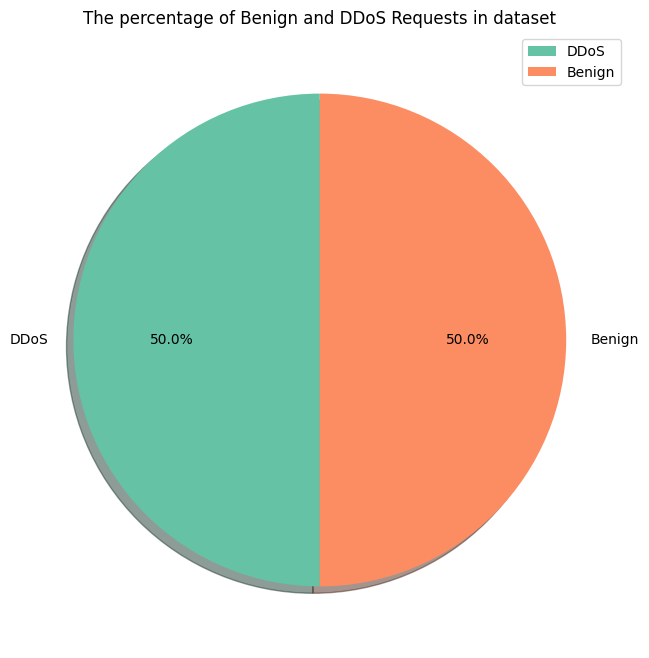

In [4]:
Label = ['DDoS','Benign']
sizes = [balance_data['Label'].value_counts()['ddos'], balance_data['Label'].value_counts()['Benign']]
plt.figure(figsize = (13,8))
colors = sn.color_palette("Set2")
plt.pie(sizes, labels=Label, autopct='%1.1f%%',shadow=True, startangle=90,colors=colors)
plt.legend(['DDoS', 'Benign'])
plt.title('The percentage of Benign and DDoS Requests in dataset')
plt.show()

In [6]:
balance_data.shape

(3198656, 85)

In [7]:
balance_data = balance_data[['Flow Duration','Src IP','Src Port','Dst IP','Dst Port','Tot Fwd Pkts','Init Bwd Win Byts','Protocol','Label']]
balance_data = balance_data.astype({'Src IP':'string','Dst IP':'string','Label':'string'})
balance_data

,Flow Duration,Src IP,Src Port,Dst IP,Dst Port,Tot Fwd Pkts,Init Bwd Win Byts,Protocol,Label
0,3974862,192.168.4.118,4504,203.73.24.75,80,29,5840,6,ddos
1,63,192.168.4.118,4504,203.73.24.75,80,1,17520,6,ddos
2,476078,192.168.4.118,4505,203.73.24.75,80,2,5840,6,ddos
3,151,192.168.4.118,4505,203.73.24.75,80,2,17520,6,ddos
4,472507,192.168.4.118,4506,203.73.24.75,80,2,5840,6,ddos
...,...,...,...,...,...,...,...,...,...
3198651,50,209.85.203.113,80,172.31.67.50,53598,1,255,6,Benign
3198652,306,172.31.69.17,54599,108.174.10.14,443,3,-1,6,Benign
3198653,362,172.31.65.49,61087,172.31.0.2,53,1,-1,17,Benign
3198654,303,172.31.67.58,61580,172.31.0.2,53,1,-1,17,Benign


In [8]:
balance_data.isnull().sum()

,0
Flow Duration,0
Src IP,0
Src Port,0
Dst IP,0
Dst Port,0
Tot Fwd Pkts,0
Init Bwd Win Byts,0
Protocol,0
Label,0


In [9]:
Selected_data=balance_data.loc[balance_data['Label'] == 'ddos'] # row with DDoS label
print(Selected_data['Src IP'].value_counts().nlargest(10))
IPcount=Selected_data['Src IP'].value_counts().nlargest(10).tolist() # times of appearance
IPs=Selected_data['Src IP'].value_counts()[:10].index.tolist() # the IP
print(IPcount)
print(IPs)

Src IP
172.31.69.28      245005
18.216.200.189    125859
18.218.229.235    125686
18.218.115.60     125203
18.218.11.51      124881
18.216.24.42      124612
18.219.9.1        124608
18.219.32.43      124590
18.218.55.126     124464
52.14.136.135     124040
Name: count, dtype: Int64
[245005, 125859, 125686, 125203, 124881, 124612, 124608, 124590, 124464, 124040]
['172.31.69.28', '18.216.200.189', '18.218.229.235', '18.218.115.60', '18.218.11.51', '18.216.24.42', '18.219.9.1', '18.219.32.43', '18.218.55.126', '52.14.136.135']


In [10]:
balance_data['Src IP'] = balance_data['Src IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))
balance_data['Dst IP'] = balance_data['Dst IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))

<Axes: >

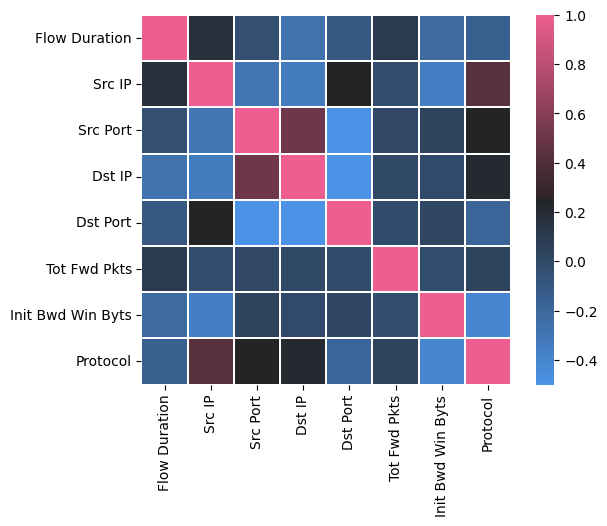

In [11]:
corr = balance_data.iloc[:,:-1].corr(method="pearson")
cmap = sn.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sn.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [13]:
X = balance_data.drop(columns=['Label'])
Y = balance_data.Label

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state =44)

label_encoder = LabelEncoder()


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = rf.predict(X_test)

# Step 6: Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Feature Importance (Optional - to understand which features are most important)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Accuracy: 1.0
Confusion Matrix:
 [[320259      0]
 [     0 319473]]
Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    320259
        ddos       1.00      1.00      1.00    319473

    accuracy                           1.00    639732
   macro avg       1.00      1.00      1.00    639732
weighted avg       1.00      1.00      1.00    639732

Feature ranking:
1. Feature Src IP (0.2748659060289034)
2. Feature Dst IP (0.21544510264375952)
3. Feature Init Bwd Win Byts (0.1774831279393335)
4. Feature Dst Port (0.10990541062686651)
5. Feature Src Port (0.07148405218753207)
6. Feature Tot Fwd Pkts (0.07049996083327288)
7. Feature Flow Duration (0.05648045714215716)
8. Feature Protocol (0.02383598259817504)


In [15]:
# Separating the target variable
X = balance_data.drop(columns=['Label'])
Y = balance_data.Label

# splitting the data into test and train with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state =44)

# instantiate the model
classifier = GaussianNB()

# fit the model
classifier.fit(X_train, y_train)

# predict train result
y_pred_train = classifier.predict(X_train)

y_pred_train

# predict test result
y_pred_test = classifier.predict(X_test)

y_pred_test

# accuracy score for the test and train models
print('Training-set accuracy score: {0:0.4f}%'. format(accuracy_score(y_train, y_pred_train)*100))
print('Model accuracy score: {0:0.4f}%'. format(accuracy_score(y_test, y_pred_test)*100))

Training-set accuracy score: 81.9011%
Model accuracy score: 81.8724%


### RANDOMFOREST

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
import numpy as np


model = RandomForestClassifier(n_estimators=100, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X, Y, cv=kf, scoring='accuracy')

print("Cross-validation accuracy scores for each fold: ", cv_scores)
print("Mean cross-validation accuracy: ", np.mean(cv_scores))
print("Standard deviation: ", np.std(cv_scores))


Cross-validation accuracy scores for each fold:  [1.         1.         0.99999844 0.99999844 1.        ]
Mean cross-validation accuracy:  0.9999993747371942
Standard deviation:  7.65787414618489e-07


In [36]:
import numpy as np
import pandas as pd

def predict_ddos(model, features):
    feature_names = ['Flow Duration', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Tot Fwd Pkts', 'Init Bwd Win Byts', 'Protocol']
    features_df = pd.DataFrame([features], columns=feature_names)

    prediction = rf.predict(features_df)

    return prediction[0]

sample_values = [3974862, 3232236662, 4504, 3410565195, 80, 29, 5840, 6]

result = predict_ddos(model, sample_values)

print(f"Prediction: {result}")


prediction --- > ['ddos']
Prediction: ddos


In [35]:
balance_data.head(1)

,Flow Duration,Src IP,Src Port,Dst IP,Dst Port,Tot Fwd Pkts,Init Bwd Win Byts,Protocol,Label
0,3974862,3232236662,4504,3410565195,80,29,5840,6,ddos


In [39]:
import joblib

joblib.dump(rf, 'random_forest_model.pkl')


['random_forest_model.pkl']

### <B>CROSS VALIDATION</B>

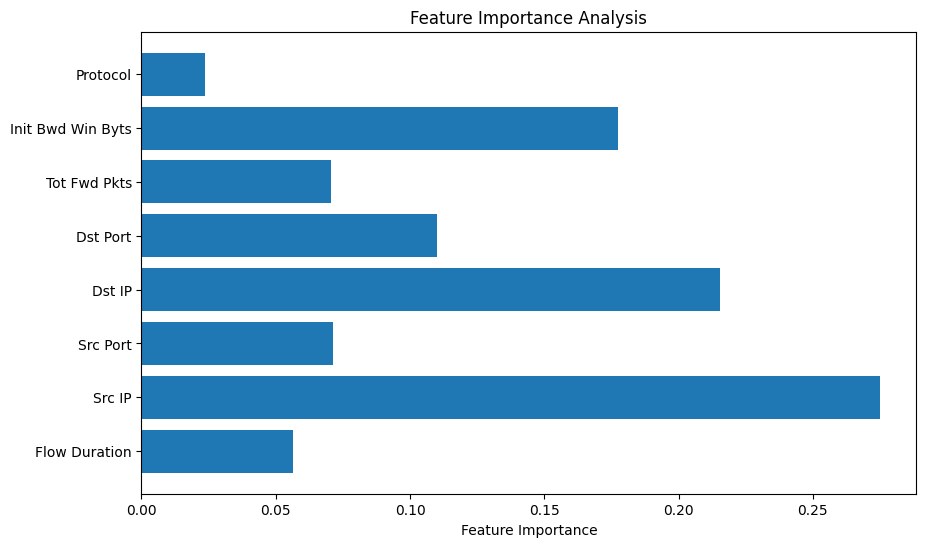

In [40]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = ['Flow Duration', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Tot Fwd Pkts', 'Init Bwd Win Byts', 'Protocol']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()


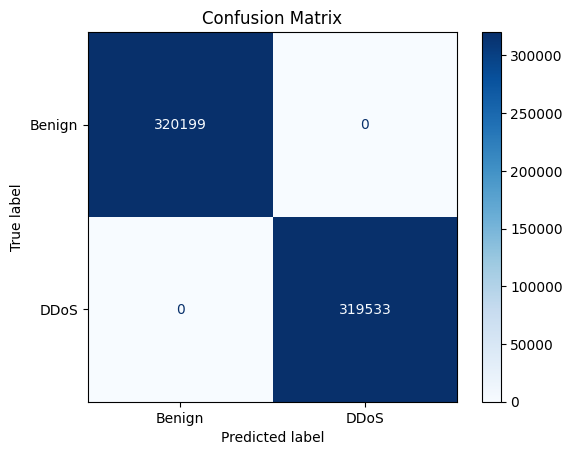

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'DDoS'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


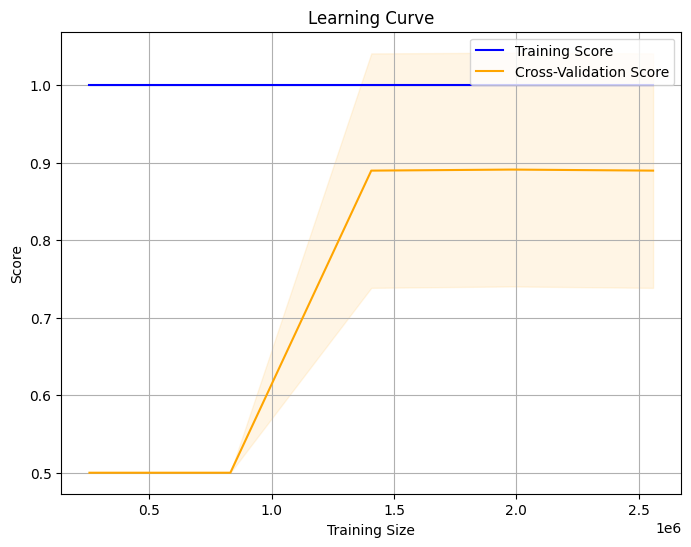

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X, Y, cv=5)

# Mean and std for training and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


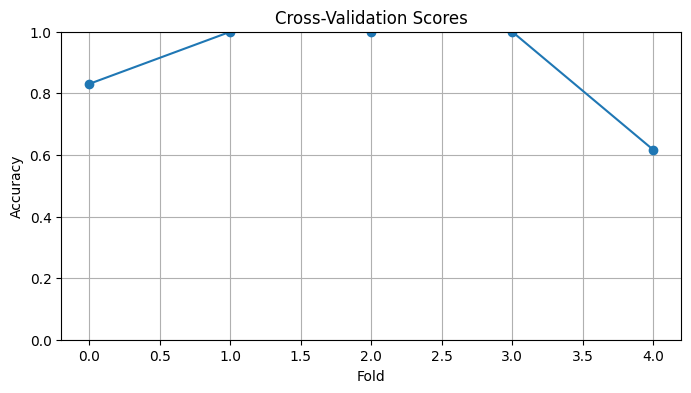

Mean Cross-Validation Accuracy: 0.8895823929453945
Standard Deviation: 0.1512028555414319


In [46]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X, Y, cv=5)

plt.figure(figsize=(8, 4))
plt.plot(cv_scores, marker='o')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid()
plt.show()

print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores)}')
print(f'Standard Deviation: {np.std(cv_scores)}')
